In [5]:
import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]  # …/collision_of_two_bodies
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


In [6]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np


In [7]:
def build_config(overrides=None):
    base = Config()
    if overrides:
        base = Config(**overrides)
    set_global_seeds(base.seed)
    return base

import logging

def run_case(case_name, overrides=None, verbose=True):
    cfg = build_config(overrides)
    base_logger = setup_logger()
    logger = logging.getLogger(f"case_{case_name.lower().replace(' ', '_')}")
    logger.setLevel(base_logger.level)
    if not logger.handlers:
        for h in base_logger.handlers:
            logger.addHandler(h)

    controller = ContinuousOptimizationController(cfg, logger=logger if verbose else None)
    result = controller.run()
    if verbose:
        logger.info("→ %s | mejor λ ≈ %.4f", case_name, -(result["best"]["lambda"] or float("nan")))
        print(result)
    return cfg, result


def visualize_best(cfg, result, horizon="short", show=False):
    best = result.get("best") or {}
    m1, m2 = best.get("m1"), best.get("m2")
    if m1 is None or m2 is None:
        print("Sin candidato válido para visualizar.")
        return

    masses = (m1, m2)
    r0 = tuple(cfg.r0[i] for i in range(len(masses)))
    v0 = tuple(cfg.v0[i] for i in range(len(masses)))

    sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
    sim = sim_builder.setup_simulation(masses=masses, r0=r0, v0=v0)
    t_end = cfg.t_end_short if horizon == "short" else cfg.t_end_long
    traj = sim_builder.integrate(sim, t_end=t_end, dt=cfg.dt)

    xy_tracks = [traj[:, idx, :2] for idx in range(traj.shape[1])]
    viz = Visualizer(headless=not show)
    viz.quick_view(xy_tracks, title=f"Trayectorias {best['m1']:.3f}, {best['m2']:.3f}")
    return xy_tracks


In [8]:
cases = {
    "Caso A (baseline)": {},
    "Caso B (semilla distinta)": {"seed": 123},
    "Caso C (búsqueda acotada)": {
        "mass_bounds": (
            (0.8, 1.2),
            (0.8, 1.2),
        ),
        "local_radius": 0.05,
    },
    "Caso D (todos los parámetros)": {
        # Simulación
        "t_end_short": 150.0,
        "t_end_long": 2000.0,
        "dt": 0.25,
        "integrator": "ias15",
        "r0": (
            (-1.5, 0.0, 0.0),
            (1.5, 0.0, 0.0),
        ),
        "v0": (
            (0.0, -0.45, 0.0),
            (0.0, 0.45, 0.0),
        ),
        # Parámetros físicos
        "mass_bounds": (
            (0.2, 5.0),
            (0.1, 4.0),
            # Agrega aquí (m3_min, m3_max) si incluyes un tercer cuerpo
        ),
        "G": 1.2,
        "x0": (-1.5, 0.0, 0.0, -0.45, 1.5, 0.0, 0.0, 0.45),
        # GA
        "pop_size": 96,
        "n_gen_step": 4,
        "crossover": 0.85,
        "mutation": 0.3,
        "selection": "tournament",
        "elitism": 2,
        "seed": 999,
        # Optimización continua
        "max_epochs": 80,
        "top_k_long": 12,
        "stagnation_window": 6,
        "stagnation_tol": 5e-4,
        "local_radius": 0.08,
        "radius_decay": 0.85,
        "time_budget_s": 1200.0,
        "eval_budget": 5000,
        # Backend / cache
        "use_gpu": "false",
        "batch_size": 128,
        "cache_exact_max": 500,
        "cache_approx_max": 1500,
        # I/O
        "artifacts_dir": "artifacts/case_d",
        "save_plots": True,
        "headless": False,
    },
}


In [9]:
results = {}
for name, overrides in cases.items():
    cfg, result = run_case(name, overrides=overrides)
    results[name] = (cfg, result)


[2025-10-21 16:54:43,558] WARNING - pymoo unavailable or setup failed: cannot import name 'SBXCrossover' from 'pymoo.operators.crossover.sbx' (c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\pymoo\operators\crossover\sbx.py). Using internal sampler.
c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-10-21 16:54:44,398] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:44,958] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:45,339] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:46,124] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:46,651] INFO - Stagnation d

{'status': 'completed', 'best': {'masses': [6.1522108186298095, 6.496240766893804], 'lambda': -4.911780802560779, 'fitness': 4.911780802560779, 'm1': 6.1522108186298095, 'm2': 6.496240766893804}, 'evals': 3600, 'epochs': 50}


[2025-10-21 16:54:48,216] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:49,179] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:49,569] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:49,951] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:50,733] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:51,128] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:51,521] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:51,600] INFO - → Caso B (semilla distinta) | mejor λ ≈ 4.9561
[2025-10-21 16:54:51,601] WARNING - pymoo unavailable or setup failed: cannot import name 'SBXCrossover' from 'pymoo.operators.crossover.sbx' (c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\pymoo\operators\crossover\sbx.py). Using internal sampler.


{'status': 'completed', 'best': {'masses': [5.928994804511322, 6.7181880107961724], 'lambda': -4.956075409662989, 'fitness': 4.956075409662989, 'm1': 5.928994804511322, 'm2': 6.7181880107961724}, 'evals': 3600, 'epochs': 50}


[2025-10-21 16:54:52,039] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:52,390] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:52,743] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:53,104] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:53,459] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:53,816] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:54,177] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:54,531] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:54,883] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:54:55,169] INFO - → Caso C (búsqueda acotada) | mejor λ ≈ 0.0002
[2025-10-21 16:54:55,170] WARNING - pymoo unavailable or setup failed: cannot import name 'SBXCrossover' from 'pymoo.operators.crossover.

{'status': 'completed', 'best': {'masses': [0.9877314426671376, 1.0755976477090765], 'lambda': -0.00018584391755696597, 'fitness': 0.00018584391755696597, 'm1': 0.9877314426671376, 'm2': 1.0755976477090765}, 'evals': 3600, 'epochs': 50}


[2025-10-21 16:55:14,266] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:55:24,218] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:55:33,139] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:55:46,362] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:55:55,251] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:56:11,354] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-21 16:56:14,245] INFO - → Caso D (todos los parámetros) | mejor λ ≈ 0.0106


{'status': 'completed', 'best': {'masses': [0.48005667900299565, 0.8561172803475939], 'lambda': -0.010555314247516018, 'fitness': 0.010555314247516018, 'm1': 0.48005667900299565, 'm2': 0.8561172803475939}, 'evals': 5076, 'epochs': 47}


Visualizando Caso A (baseline)


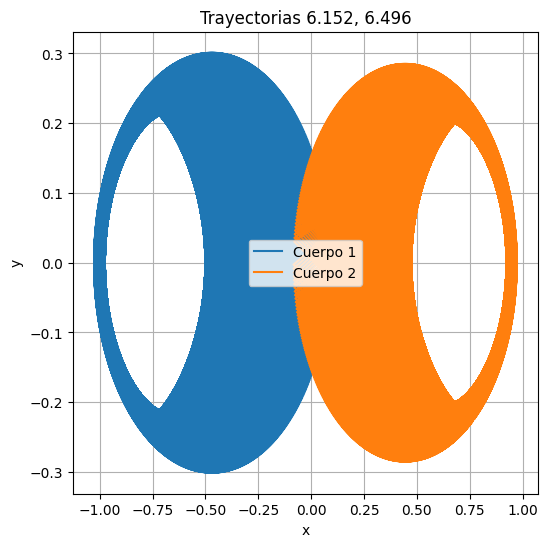

Visualizando Caso B (semilla distinta)


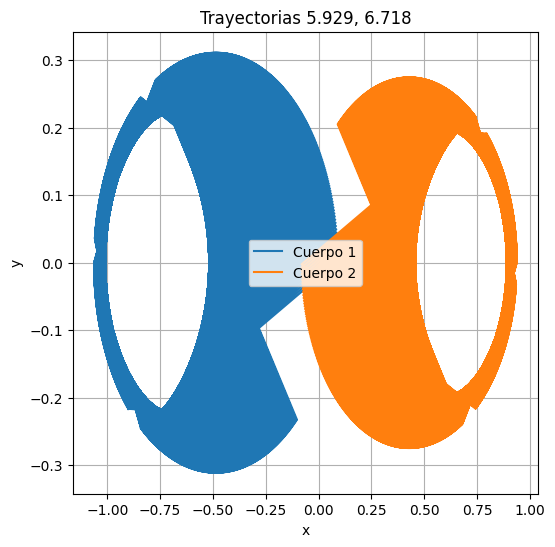

Visualizando Caso C (búsqueda acotada)


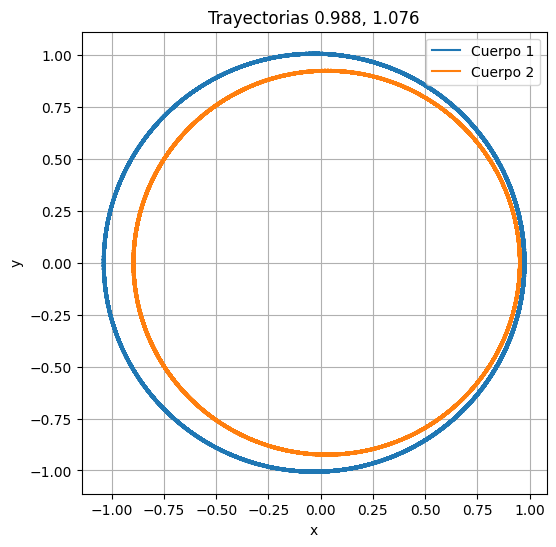

Visualizando Caso D (todos los parámetros)


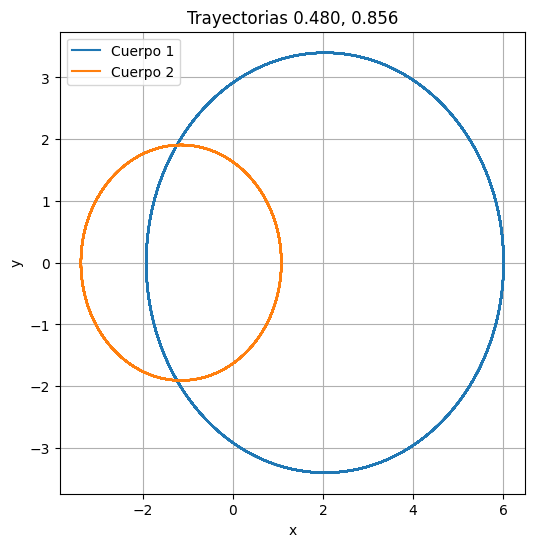

In [11]:
for name, (cfg, result) in results.items():
    print(f"Visualizando {name}")
    visualize_best(cfg, result, horizon="long", show=True)
